# Testing an 'online' estimator for $R_n$

### Imports

In [10]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

### Noise Generator $N_t$
A core assumption of the SPS algorithm is that the noise is zero mean, symmetric and iid

# ARMAX Generator
Class for simulating a system of the form $A(q)y(t) = B(q)u(t) + C(q)e(t) + D$

This class has been developed with the intention of running it in 'online' mode where an update function will be called at each cycle

In [2]:
class ARMAX_Generator:
    def __init__(self, A: list, B: list, C: list, D: list, input_controller) -> None:
        # System Parameters
        self.A = A  # AR coefficients
        self.B = B  # X input coefficients
        self.C = C  # MA coefficients
        self.D = D  # Constant term

        self.order = max(len(A), len(B), len(C)) 

        # TODO Replace this with actual controller logic
        def temp_input_controller(y, u) -> float: 
            sigma = 0.1
            return 0.4 * y[-1] + np.random.normal(sigma)

        # TODO replace this with the input parameter in the constructor
        self.input_controller = temp_input_controller #input_controller

        # State
        # The below vectors should all be of the same length equal to the current time step
        self.y = []  # Output of the system
        self.u = []  # Input to the system
        self.e = []  # Noise input to the system

    # TODO Replace this with a user-provided noise function
    def generate_noise(self) -> float:
        sigma = 0.1
        self.e.append(np.random.normal(0, sigma))
    
    # Generate new datapoints for the next timestep and append it to the system's state
    def generate_datapoint(self):
        # AR component
        overlap = min(len(self.A)-1, len(self.y)) # Calculate the overlap between A(2), A(3), A(...) and the past inputs
        ar_sum = np.matmul(self.A[1:overlap+1:][::-1], self.y[-overlap::]) # Reverse the order of the coefficients and multiply the matrices

        # Exogenous input component
        overlap = min(len(self.B), len(self.u))
        exo_sum = np.matmul(self.B[:overlap:][::-1], self.u[-overlap::])

        # MA component
        overlap = min(len(self.C), len(self.e))
        ma_sum = np.matmul(self.C[:overlap:][::-1], self.e[-overlap::])

        # Compute output
        self.y.append( -ar_sum + exo_sum + ma_sum + self.D / self.A[0])
        self.u.append( self.input_controller(self.y, self.u) )

# SPS Algorithm

In [21]:
class SPS:
    def __init__(self, p:float=(1-5/40), m:int=40, q:int=5, n:int=0, T:int=1) -> None:
        self.p = p # Confidence probability
        self.m = m # Integer m such that p = 1 − q/m
        self.q = q # Integer q such that p = 1 − q/m
        self.n = n # Number of data points
        self.T = T # block SPS window size
        self.T_repetitions_left: int = 0
        
        self.alpha = None # Random signs
        self.pi = None    # Random permutation

    # Process one time step
    # This is the main function for the real-time SPS implementation
    def update(self) -> None:
        self.n += 1
        self.append_alpha_column()
        self.generate_random_perm()

    # Generate a column of alpha values
    # This should be called whenever we add another data sample (n -> n+1)
    def append_alpha_column(self) -> None:
        new_col = None

        if self.T > 1 and self.T_repetitions_left > 0:
            self.T_repetitions_left -= 1 # Decrement repetitions

            # Repeat the last column in the array
            new_col = self.alpha[:, [-1]]

        else:
            # Check if we need to reset T
            if self.T > 1:
                self.T_repetitions_left = self.T - 1

            # Generate new column of random values
            options = [-1, 1]
            new_col = np.transpose(np.array([[np.random.choice(options) for x in range(self.m)]]))

        # Update the state of the class instance
        if self.alpha is None:
            self.alpha = new_col
        else:
            self.alpha = np.concatenate([self.alpha, new_col], axis=1)

    # Generates m-by-n matrix of integers for ordering SPS indicators
    # TODO Determine if there's anyway to avoid regenerating old values in the pi matrix. 
    def generate_random_perm(self) -> None:
        self.pi = np.array([np.random.permutation(range(self.n)) for x in range(self.m)]) 

    # TODO Test this code
    def least_square_estimator(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        theta_hat = np.linalg.lstsq(np.matmul(np.transpose(X), X), np.matmul(np.transpose(X), y))
        
        return theta_hat
    
    def sps_indicator(self, y, u, A_star, B_star, C_star, D_star, controller, createFeatureMatrix) -> bool:
        A_yt = self.basic_filter(A_star, y) # Compute A(q)y_t
        B_ut = self.basic_filter(B_star, u) # Compute B(q)u_t

        diff_AB = A_yt - B_ut

        # Reconstruct the noise C^-1(A(q)y_t - B(q)u_t)
        nt_theta = self.filter([1], C_star, diff_AB)

    # FIR Filter where the A matrix is [1]
    def basic_filter(self, B: np.ndarray, X: np.ndarray) -> np.ndarray:
        return np.convolve(B, X)[:len(X)]
    
    def filter(B: np.ndarray, A: np.ndarray, X) -> np.ndarray:
        return scipy.signal.lfilter(B, A, X)


# Testing

In [20]:
# SPS Testing
sps = SPS(p=1-1/8, T=1)

for i in range(10):
    sps.update()
    
print(sps.alpha)
print(sps.pi)

B = [1,2,3]
X = [1,2,3,4,5]
print(sps.basic_filter(B, X))
scipy.signal.lfilter(B, [1.0], X)

[[-1 -1  1  1  1  1  1  1  1 -1]
 [ 1  1  1 -1 -1 -1  1  1  1 -1]
 [ 1 -1  1 -1  1 -1 -1  1 -1 -1]
 [-1 -1 -1  1 -1  1  1  1 -1 -1]
 [-1  1 -1  1  1 -1 -1  1 -1  1]
 [ 1 -1  1 -1 -1  1  1  1 -1 -1]
 [-1  1 -1 -1 -1  1 -1 -1  1  1]
 [ 1 -1 -1 -1  1  1  1  1  1  1]
 [ 1 -1 -1  1  1  1  1  1  1  1]
 [ 1  1  1 -1  1  1 -1  1 -1 -1]
 [-1 -1  1  1 -1 -1 -1 -1  1 -1]
 [ 1  1  1 -1 -1  1  1  1  1 -1]
 [-1 -1 -1  1  1  1 -1  1  1 -1]
 [ 1  1  1 -1  1  1  1  1  1  1]
 [ 1 -1 -1 -1  1 -1  1  1 -1  1]
 [-1 -1  1 -1 -1 -1  1 -1 -1  1]
 [ 1  1  1 -1 -1 -1 -1 -1 -1  1]
 [ 1 -1  1  1  1 -1 -1 -1  1 -1]
 [-1 -1  1  1 -1  1 -1  1  1 -1]
 [ 1 -1  1  1  1 -1 -1 -1  1 -1]
 [-1  1 -1 -1 -1  1  1 -1 -1  1]
 [ 1 -1 -1  1 -1  1 -1 -1 -1 -1]
 [ 1  1  1 -1 -1  1 -1  1  1 -1]
 [ 1 -1  1  1  1  1  1  1  1 -1]
 [-1  1  1 -1 -1 -1  1  1  1  1]
 [ 1  1  1 -1  1  1  1  1  1  1]
 [-1 -1  1  1  1  1  1  1 -1  1]
 [ 1  1  1  1 -1  1 -1 -1 -1 -1]
 [ 1 -1 -1  1  1  1  1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1  1 -1  1 -1]
 [-1 -1 -1

array([ 1.,  4., 10., 16., 22.])

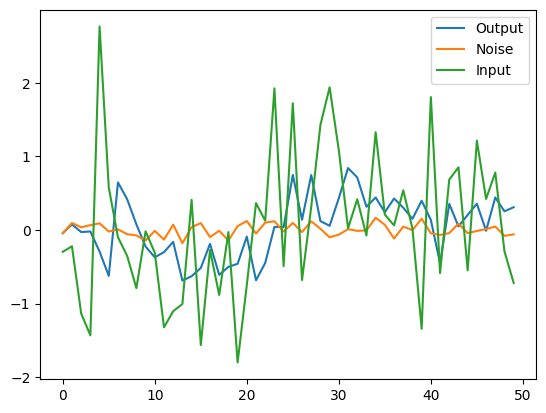

In [69]:
# Test the ARMAX Generator
theta_real = [0.44, 0.33, 0]
A = [1, -theta_real[0]];    # AR coefficients
B = [0, theta_real[1]];     # MA coefficients
C = [1, theta_real[2]];     # input coefficients
D = 0;                      # Constant term
generator = ARMAX_Generator(A, B, C, D, None)

for i in range(50):
    generator.generate_noise()
    generator.generate_datapoint()



fig = plt.figure()
plt.plot(generator.y)
plt.plot(generator.e)
plt.plot(generator.u)
plt.legend(['Output', 'Noise', 'Input'])
plt.show()

In [127]:
# TODO: PEM Estimate

# Model Orders
na = 1  # Order of A(q)
nb = 1  # Order of B(q)
nc = 0  # Order of C(q)
nk = 1  # Input delay

